# CS289A Project F: Random Forest

In [1]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
import random
random.seed(246810)
np.random.seed(246810)
import warnings
warnings.filterwarnings('ignore')


In [2]:
eps = 1e-5  # a small number
# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000

h = np.vectorize(w)


## 1. Set up dataset

In [23]:
# some scripts to merge the SW time and HW time + features CSV files
# no need to run again !!

# path_chstone= '../data/baseline_chstone.csv'
# chstone = pd.read_csv(path_chstone, delimiter=',')

# path_random = '../data/baseline_random.csv'
# random = pd.read_csv(path_random, delimiter=',')
# random.sort_values(by = ['program'])

# random_sw=pd.read_csv('../data/sw_perf_random.csv', delimiter=',')
# chstone_sw=pd.read_csv('../data/sw_perf_chstone.csv', delimiter=',')

# merged_random = random.merge(random_sw, left_on='program', right_on='program')
# merged_chstone = chstone.merge(chstone_sw, left_on='program', right_on='program')

# merged_random.to_csv('../data/final_random.csv', index=False)
# merged_chstone.to_csv('../data/final_chstone.csv',index=False)


In [3]:
dataset = "csmith_random_programs"
data = pd.read_csv('../data/final_random.csv', delimiter=',')

### Part (a). Pre-process the data


In [4]:
# set out training set to be 70% of total; 30% 
# random_idx = random.randint(0, np.shape(data)[0]) #27
num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3
print(train_speedup)
# log_train_speedup = np.log10(train_speedup.astype(float))
# log_test_speedup = np.log10(test_speedup.astype(float))


(9011, 116)
(3862, 116)
(12873, 116)
[2915.27039334195 3064.5126890095776 3127.9902745113 ...
 2596.5991783791956 2804.3891404735623 3077.551395099053]


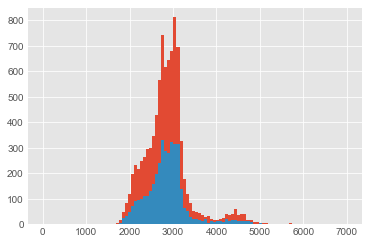

In [121]:
# EDA of speed up from training set
plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
plt.hist(train_speedup, bins=100, range =(0, 7000))
plt.hist(test_speedup, bins=100, range = (0, 7000))

plt.show()


In [5]:
# Get binary preduction output: is speedup (HW vs SW) > 2800 
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1]
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1]
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]

0.5433359227610698
0.5468669083376488


In [6]:
def evaluate(clf, print_splits=True):
    print("Cross validation", cross_val_score(clf, X, y, cv=3))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        if print_splits == True:
            print("First splits", first_splits)

In [7]:

# 
# Basic decision tree
print('==============================================')
print("sklearn's decision tree")
params = {
    "max_depth": 5,
    "min_samples_leaf": 20,
}
clf = DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf, print_splits=True)

sklearn's decision tree
Cross validation [0.76464714 0.76198402 0.78354978]


In [144]:
from pydot import graph_from_dot_data
import io
out = io.StringIO()
export_graphviz(clf, out_file=out, feature_names=features, class_names=class_names)
# For OSX, may need the following for dot: brew install gprof2dot
graph = graph_from_dot_data(out.getvalue())
graph_from_dot_data(out.getvalue())[0].write_pdf("{}-tree-depth{}.pdf".format(dataset, max_depth))

In [145]:
class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(random_state=i, **self.params) for i in range(self.n)
        ]

    def fit(self, X, y):
        for i in range(self.n):
            idx = np.random.randint(0, X.shape[0], X.shape[0])
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
        return self

    def predict(self, X):
        yhat = [self.decision_trees[i].predict(X) for i in range(self.n)]
        # TODO: compute yhat_avg for BaggedTrees
        ### start code ###
        yhat_avg = np.round(np.mean(yhat, axis=0), decimals=0)
        ### end code ###
        return yhat_avg
# Bagged trees
# print(" bagged trees")
# bt = BaggedTrees(params, n=N)
# bt.fit(X, y)
# evaluate(bt)

In [147]:
class RandomForest(BaggedTrees):

    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        params['max_features'] = m
        super().__init__(params=params, n=n)

In [148]:
class BoostedRandomForest(RandomForest):

    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        i = 0
        while i < self.n:
            idx = np.random.choice(X.shape[0], size=X.shape[0], p=self.w)
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
            wrong = np.abs((y - self.decision_trees[i].predict(X)))
            error = wrong.dot(self.w) / np.sum(self.w)
            self.a[i] = 0.5 * np.log((1 - error) / error)
            # Update w
            wrong_idx = np.where(wrong > 0.5)[0]
            right_idx = np.where(wrong <= 0.5)[0]
            # TODO: fill in the code for updating 'self.w'
            
            ### start code ###
            self.w[wrong_idx] = self.w[wrong_idx]*np.exp(self.a[i])
            self.w[right_idx] = self.w[right_idx]*np.exp(-self.a[i])
            self.w = self.w / sum(self.w)
            #print(self.w)
            i += 1
        ### end code ###
        return self
    
    def predict(self, X):
        yhat = [self.a[i]*self.decision_trees[i].predict(X) for i in range(self.n)]
        yhat_BoostedRandomForest = np.round(np.sum(yhat, axis=0) / np.sum(self.a))
        return yhat_BoostedRandomForest

In [16]:
params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
    "n_estimators": 200
}
N = 200
max_depth = 5
#rf = RandomForestClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
rf = RandomForestClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
evaluate(rf, print_splits=True)
print('random forest test accuracy: ', accuracy_score(rf.predict(X_test), y_test))

Cross validation [0.77463382 0.75865513 0.78121878]
random forest test accuracy:  0.7698083894355257


In [29]:
params = {
    #"max_depth": 5,
    #"min_samples_leaf": 10,
    "random_state":0,
    "min_samples_split":2
}

# Constant classifier
print('==============================================')
print("Constant classifier")
print('constant classifier test accuracy: ', accuracy_score(np.zeros_like(y_test), y_test))


# Basic decision tree
print('==============================================')
print("Decsion Tree classifier")
clf = DecisionTreeClassifier(**params)
clf.fit(X, y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('sklearn decision tree test accuracy: ', accuracy_score(clf.predict(X_test), y_test))


params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
    "n_estimators": 300,
    "random_state":0,
    "min_samples_split":2
}

# Random forest
print('==============================================')
print("Random Forest classifier")
rf = RandomForestClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('random forest test accuracy: ', accuracy_score(rf.predict(X_test), y_test))

from sklearn.ensemble import ExtraTreesClassifier
print('==============================================')
print("Extremely Randomized Forest classifier")
ext = ExtraTreesClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
ext.fit(X,y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('Extreme random forest test accuracy: ', accuracy_score(ext.predict(X_test), y_test))   
                           
# Gradient boosted random forest
print('==============================================')
print("Gradient Boosting classifier")
boosted = GradientBoostingClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
boosted.fit(X, y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('boosted random forest test accuracy: ', accuracy_score(boosted.predict(X_test), y_test))
# np.savetxt('{}.out'.format(dataset), boosted.predict(X_test))

Constant classifier
constant classifier test accuracy:  0.4531330916623511
Decsion Tree classifier
cross validation [0.77703827 0.77136515 0.76415094 0.77136515 0.78079911]
sklearn decision tree test accuracy:  0.6802175038839979
Random Forest classifier
cross validation [0.7775929  0.77247503 0.76470588 0.77413984 0.78135405]
random forest test accuracy:  0.7700673226307613
Extremely Randomized Forest classifier
cross validation [0.7775929  0.77247503 0.76470588 0.77413984 0.78135405]
Extreme random forest test accuracy:  0.7589331952356292
Gradient Boosting classifier
cross validation [0.7775929  0.77247503 0.76470588 0.77413984 0.78135405]
boosted random forest test accuracy:  0.7599689280165717


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
    "n_estimators": 200,
    "random_state":0,
    "min_samples_split":2
}

params2 = {
    #"max_depth": 5,
    #"min_samples_leaf": 10,
    "n_estimators": 200,
    "random_state":0,
    #"min_samples_split":2
}

logreg = LogisticRegression(random_state=1)
gnb = GaussianNB()
rf = RandomForestClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
ext = ExtraTreesClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
ada = AdaBoostClassifier(**params2)
grad = GradientBoostingClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
eclf = VotingClassifier(estimators=[('lr', logreg), ('gnb', gnb), ('rf', rf), ('ext', ext),('ada', ada), ('grad', grad)], voting='hard')

for clf, label in zip([logreg, gnb, rf, ext,ada,grad,eclf], [
    'Logistic Regression', 'naive Bayes',
    'Random Forest', 'Extra Trees', "AdaBoost", "Gradient Boosting",'Voting Classfier']):
    clf.fit(X,y)
    cross_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
    test_scores = accuracy_score(clf.predict(X_test), y_test)
    print("Cross validation: %0.4f (+/- %0.2f) [%s]" % (cross_scores.mean(), cross_scores.std(), label))
    print("Test accuracy: %0.4f (+/- %0.2f) [%s]" % (test_scores.mean(), test_scores.std(), label))

Cross validation: 0.7645 (+/- 0.01) [Logistic Regression]
Test accuracy: 0.7589 (+/- 0.00) [Logistic Regression]
Cross validation: 0.7614 (+/- 0.01) [naive Bayes]
Test accuracy: 0.7576 (+/- 0.00) [naive Bayes]
Cross validation: 0.7716 (+/- 0.01) [Random Forest]
Test accuracy: 0.7698 (+/- 0.00) [Random Forest]
Cross validation: 0.7646 (+/- 0.01) [Extra Trees]
Test accuracy: 0.7582 (+/- 0.00) [Extra Trees]
Cross validation: 0.7691 (+/- 0.01) [AdaBoost]
Test accuracy: 0.7628 (+/- 0.00) [AdaBoost]
Cross validation: 0.7692 (+/- 0.01) [Gradient Boosting]
Test accuracy: 0.7644 (+/- 0.00) [Gradient Boosting]


### Setup dataset


In [ ]:
#dataset = "titanic"
dataset = "spam"
params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
}
N = 200

if dataset == "titanic":
    # Load titanic data
    path_train = 'titanic_training.csv'
    data = genfromtxt(path_train, delimiter=',', dtype=None)
    path_test = 'titanic_testing_data.csv'
    test_data = genfromtxt(path_test, delimiter=',', dtype=None)
    y = data[1:, 0]  # label = survived
    path_y_test = 'titanic_testing_labels_only.txt'
    y_test = genfromtxt(path_y_test, delimiter=',', dtype=None)
    class_names = ["Died", "Survived"]

    labeled_idx = np.where(y != b'')[0]
    y = np.array(y[labeled_idx], dtype=np.int)
    print("Part (a): preprocessing the titanic dataset")
    X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]
    Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
    assert X.shape[1] == Z.shape[1]
    features = list(data[0, 1:]) + onehot_features

elif dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = 'spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    path_y_test = 'spam_test_labels_only.txt'
    y_test = genfromtxt(path_y_test, delimiter=',', dtype=None)
    class_names = ["Ham", "Spam"]

else:
    raise NotImplementedError("Dataset %s not handled" % dataset)

print('==============================================')
print("Features", features)
print('==============================================')
print("Train/test size", X.shape, Z.shape)


### Part (b). Implement basic decision tree

Implement the

**information gain**, i.e., entropy of the parent node minus the weighted sum of entropy of the child nodes

**Gini purification**, i.e., Gini impurity of the parent node minus the weighted sum of Gini impurities of the child nodes splitting rules for greedy decision tree learning.


In [ ]:
class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def entropy(y):
        if y.size == 0:
            return 0
        p0 = np.where(y < 0.5)[0].size / y.size
        if np.abs(p0) < 1e-10 or np.abs(1 - p0) < 1e-10:
            return 0
        # TODO: compute entropy_value
        ### start entropy_code ###
        entropy_value = -p0*np.log(p0) 
        ### end entropy_code ###

        return entropy_value

    @staticmethod
    def information_gain(X, y, thresh):
        base = DecisionTree.entropy(y)
        y0 = y[np.where(X < thresh)[0]]
        p0 = y0.size / y.size
        y1 = y[np.where(X >= thresh)[0]]
        p1 = y1.size / y.size
        # TODO: compute entropy_children

        ### start information_gain_code ###
        entropy_children = p0*DecisionTree.entropy(y0) + p1*DecisionTree.entropy(y1)
        ### end information_gain_code ###

        return base - entropy_children

    @staticmethod
    def gini_impurity(X, y, thresh):
        if y.size == 0:
            return 0
        p0 = np.where(y < 0.5)[0].size / y.size
        if np.abs(p0) < 1e-10 or np.abs(1 - p0) < 1e-10:
            return 0
        # TODO: compute entropy_value

        ### start gini_impurity_code ###
        gini_impurity_value = p0*(1-p0) 
        ### end gini_impurity_code ###

        return gini_impurity_value

    @staticmethod
    def gini_purification(X, y, thresh):
        base = DecisionTree.gini_impurity(y)
        y0 = y[np.where(X < thresh)[0]]
        p0 = y0.size / y.size
        y1 = y[np.where(X >= thresh)[0]]
        p1 = y1.size / y.size
        # TODO: compute entropy_children

        ### start gini_purification_code ###
        gini_impurity_children = p0*DecisionTree.gini_impurity(y0) + p1*DecisionTree.gini_impurity(y1)
        ### end gini_purification_code ###

        return base - gini_impurity_children

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(
                    np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([
                    self.information_gain(X[:, i], y, t) for t in thresh[i, :]
                ])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(
                np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(
                X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(
                X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())


In [ ]:
# debug = DecisionTree
# #arr = np.random.rand(10,)
# arr = np.array([0.1,1,1,1,1,1])
# print(arr)
# debug.entropy(arr)

### Part (c). Train a shallow decision tree on the Titanic and Spam dataset and visualize your tree.


#### Train and evaluate the decision tree


In [ ]:
# Basic decision tree
max_depth = 3
print('==============================================')
print("Part (a, c): simplified decision tree")
dt = DecisionTree(max_depth=max_depth, feature_labels=features)
dt.fit(X, y)
print('==============================================')
print("Tree structure", dt.__repr__())

# Basic decision tree
print('==============================================')
print("Part (c): sklearn's decision tree")
params = {
    "max_depth": max_depth,
    "min_samples_leaf": 10,
}
clf = DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf)


**Visualize your tree**


In [133]:
from pydot import graph_from_dot_data
import io
out = io.StringIO()
export_graphviz(clf, out_file=out, feature_names=features, class_names=class_names)
# For OSX, may need the following for dot: brew install gprof2dot
graph = graph_from_dot_data(out.getvalue())
graph_from_dot_data(out.getvalue())[0].write_pdf("{}-tree-depth{}.pdf".format(dataset, max_depth))


### Part (d). Implement bagged trees


In [ ]:
class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(random_state=i, **self.params) for i in range(self.n)
        ]

    def fit(self, X, y):
        for i in range(self.n):
            idx = np.random.randint(0, X.shape[0], X.shape[0])
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
        return self

    def predict(self, X):
        yhat = [self.decision_trees[i].predict(X) for i in range(self.n)]
        # TODO: compute yhat_avg for BaggedTrees
        ### start code ###
        yhat_avg = np.round(np.mean(yhat, axis=0), decimals=0)
        ### end code ###
        return yhat_avg


### Part (e). Apply bagged trees to the titanic and spam datasets.

Find and state the most common splits made at the root node of the trees.


In [ ]:
# Bagged trees
print("Part (e): bagged trees")
bt = BaggedTrees(params, n=N)
bt.fit(X, y)
evaluate(bt)

### Part (f). Implement random forests


In [ ]:
class RandomForest(BaggedTrees):

    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        params['max_features'] = m
        super().__init__(params=params, n=n)


### Part (g). Apply bagged random forests to the titanic and spam datasets.

Find and state the most common splits made at the root node of the trees.


In [ ]:
# Random forest
print("Part (g): random forest")
rf = RandomForest(params, n=N, m=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
evaluate(rf)


### Part (h). Implement AdaBoost algorithm


In [ ]:
class BoostedRandomForest(RandomForest):

    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        i = 0
        while i < self.n:
            idx = np.random.choice(X.shape[0], size=X.shape[0], p=self.w)
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
            wrong = np.abs((y - self.decision_trees[i].predict(X)))
            error = wrong.dot(self.w) / np.sum(self.w)
            self.a[i] = 0.5 * np.log((1 - error) / error)
            # Update w
            wrong_idx = np.where(wrong > 0.5)[0]
            right_idx = np.where(wrong <= 0.5)[0]
            # TODO: fill in the code for updating 'self.w'
            
            ### start code ###
            self.w[wrong_idx] = self.w[wrong_idx]*np.exp(self.a[i])
            self.w[right_idx] = self.w[right_idx]*np.exp(-self.a[i])
            self.w = self.w / sum(self.w)
            #print(self.w)
            i += 1
        ### end code ###
        return self
    
    def predict(self, X):
        yhat = [self.a[i]*self.decision_trees[i].predict(X) for i in range(self.n)]
        yhat_BoostedRandomForest = np.round(np.sum(yhat, axis=0) / np.sum(self.a))
        return yhat_BoostedRandomForest


In [ ]:
# Boosted random forest
print("Part (h): boosted random forest")
boosted = BoostedRandomForest(params, n=N, m=np.int(np.sqrt(X.shape[1])))
boosted.fit(X, y)
evaluate(boosted)


### Part (i). Summarize the performance evaluation of: a single decision tree, bagged trees, random forests, and boosted trees.


In [134]:
params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
}
N = 200
max_depth = 5

# Constant classifier
print('==============================================')
print("Part (0): constant classifier")
print('constant classifier test accuracy: ', accuracy_score(np.zeros_like(y_test), y_test))

# Basic decision tree
print('==============================================')
print("Part (c): simplified decision tree")
dt = DecisionTree(max_depth=max_depth, feature_labels=features)
dt.fit(X, y)
print('Basic decision tree test accuracy: ', accuracy_score(dt.predict(Z), y_test))

# Basic decision tree
print('==============================================')
print("Part (c): sklearn's decision tree")
params = {
    "max_depth": max_depth,
    "min_samples_leaf": 10,
}
clf = DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf, print_splits=True)
print('sklearn decision tree test accuracy: ', accuracy_score(clf.predict(Z), y_test))


# Bagged trees
print('==============================================')
print("Part (e): bagged trees")
bt = BaggedTrees(params, n=N)
bt.fit(X, y)
evaluate(bt, print_splits=True)
print('bagged trees test accuracy: ', accuracy_score(bt.predict(Z), y_test))


# Random forest
print('==============================================')
print("Part (g): random forest")
rf = RandomForest(params, n=N, m=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
evaluate(rf, print_splits=True)
print('random forest test accuracy: ', accuracy_score(rf.predict(Z), y_test))


# Boosted random forest
print('==============================================')
print("Part (h): boosted random forest")
boosted = BoostedRandomForest(params, n=N, m=np.int(np.sqrt(X.shape[1])))
boosted.fit(X, y)
evaluate(boosted, print_splits=True)
print('boosted random forest test accuracy: ', accuracy_score(boosted.predict(Z), y_test))
print(dataset)
np.savetxt('{}.out'.format(dataset), boosted.predict(Z))


Part (0): constant classifier
constant classifier test accuracy:  0.4531330916623511
Part (c): simplified decision tree


NameError: name 'DecisionTree' is not defined

### Part (j). For the spam dataset only: Describe what kind of data are the most challenging to classify and which are the easiest.


In [ ]:
if dataset == 'titanic':
    import sys
    sys.exit()
# The following is for the spam dataset only.
# Sample code for determining which data are easier/harder to classify
print("\n\nPart (i): easy/hard examples")
A = np.argsort(boosted.w)
tail = 1000
bits = np.array([np.sum(X[A[i], :-7]) for i in range(X.shape[0])])
print(
    "Number of easiest %s samples containing >= 2 feature counts:" % tail,
    np.sum(bits[:tail] >= 2))
print("Number of hardest %s samples containing < 2 feature counts:" % tail,
      np.sum(bits[-tail:] < 2))
bits = np.array([np.sum(X[A[i], :]) for i in range(X.shape[0])])
print(
    "Number of easiest %s samples containing >= 5 feature counts:" % tail,
    np.sum(bits[:tail] >= 5))
print("Number of hardest %s samples containing < 5 feature counts:" % tail,
      np.sum(bits[-tail:] < 5))
idxes = 200 - np.where(bits[-200:] > 7)[0]
print("Most challenging samples: Examples among the 200 data most likely "
      "to be sampled which contained at least 7 feature counts")
for idx in idxes:
    print('Example:', class_names[y[A[-idx]]],
          [x for x in zip(features, X[A[-idx], :]) if x[1] > 0],
          bits[-idx])
